# Fine Tuning of Bert for Classification

In this notebook, the Bert model is finetuned on the data  prepared for sentiment classification. We are using here the classification approach and for finding the polarity score we calculate the polarity based on the probabilieties of positive and negative class after prediction.

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.6 MB/s eta 0:00:00


In [2]:
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 12.5 MB/s eta 0:00:00


In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay, recall_score,precision_score, f1_score
import scipy
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
from tabulate import tabulate
from tqdm import trange
import random
#import locale
#locale.getpreferredencoding = lambda: "UTF-8"
import os
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
  !nvidia-smi

Thu Jun  1 11:14:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Read Data

In [7]:
!wget https://www.dropbox.com/s/vm1xl9r68czt1so/all_sent_without_context_new1.csv

--2023-06-01 11:14:38--  https://www.dropbox.com/s/vm1xl9r68czt1so/all_sent_without_context_new1.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/vm1xl9r68czt1so/all_sent_without_context_new1.csv [following]
--2023-06-01 11:14:38--  https://www.dropbox.com/s/raw/vm1xl9r68czt1so/all_sent_without_context_new1.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucff433ec2c18104428ef2ec83e6.dl.dropboxusercontent.com/cd/0/inline/B9Jz5U5lVg9A6p1MqOApzr_6iQ5s1b0Zsn2XMXJz4VCAHcT1DsCkqBlWu2qdHaWSK2NuZrC1v0C8XCrFp7NKh1ManebubeZEL2o4XuAJC9b7JvWKIIGO6cbuczcp4X12JU4NdGk_-e0-o51JOvaGrj3W__3E2lg7YqpEU6eNGxGzow/file# [following]
--2023-06-01 11:14:38--  https://ucff433ec2c18104428ef2ec83e6.dl.dropboxusercontent.com/cd/0/inline/B9Jz5U5lVg9A6p

In [8]:
df=pd.read_csv("all_sent_without_context_new1.csv",delimiter="|")
df=df.dropna(subset=["sentences"])

<ipython-input-8-ca5f8ccd3766>:1: DtypeWarning: Columns (7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("all_sent_without_context_new1.csv",delimiter="|")


In [9]:
df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,company,datatype,date,domain,esg_topics,internal,symbol,title,url,sentences,Sentiment_annot
0,0,0,0,2,Beiersdorf AG,sustainability_report,2021-03-31,NaN,"['CleanWater', 'GHGEmission', 'ProductLiabilit...",1,BEI,BeiersdorfAG Sustainability Report 2021,NaN,sustainability highlight report care beyond sk...,positive
1,1,1,1,2,Beiersdorf AG,sustainability_report,2021-03-31,NaN,"['CleanWater', 'GHGEmission', 'ProductLiabilit...",1,BEI,BeiersdorfAG Sustainability Report 2021,NaN,"in 2021, we successfully reduced our carbon fo...",positive
2,2,2,2,2,Beiersdorf AG,sustainability_report,2021-03-31,NaN,"['CleanWater', 'GHGEmission', 'ProductLiabilit...",1,BEI,BeiersdorfAG Sustainability Report 2021,NaN,"by the end of 2021, as our consumer business r...",positive
3,3,3,3,2,Beiersdorf AG,sustainability_report,2021-03-31,NaN,"['CleanWater', 'GHGEmission', 'ProductLiabilit...",1,BEI,BeiersdorfAG Sustainability Report 2021,NaN,"we are proud of this result, because it proves...",positive
4,4,4,4,2,Beiersdorf AG,sustainability_report,2021-03-31,NaN,"['CleanWater', 'GHGEmission', 'ProductLiabilit...",1,BEI,BeiersdorfAG Sustainability Report 2021,NaN,decoupling human economic activity from natura...,neutral


## Prepare Model & Train

In [10]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [11]:
label_mapping = {"positive": 2, "negative": 0, "neutral": 1}

# Encode string labels to integers using the label mapping
df['Sentiment_annot_enc'] = df['Sentiment_annot'].map(label_mapping)
df1=df[["sentences","Sentiment_annot_enc"]]
df1=df1.rename(columns={"sentences":"text","Sentiment_annot_enc":"labels"})

Split into train, validation and test set

In [12]:
train,temp = train_test_split(df1, test_size=0.3) 
val,test = train_test_split(temp, test_size=0.5) 

In [13]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

Tokenize the sentences and prepare data sets:

In [14]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=64)

In [15]:
train_tok = train_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/518740 [00:00<?, ? examples/s]

In [16]:
val_tok = val_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/111159 [00:00<?, ? examples/s]

In [17]:
test_tok = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/111159 [00:00<?, ? examples/s]

Download model for text classification

In [18]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Prepare metrics

In [19]:
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds,average=None)
    recall = recall_score(labels, preds,average=None)
    

    return {"accuracy": accuracy,"precision": precision, "recall": recall}

Train the model

In [20]:
import torch
import torch.nn as nn

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=124,
    per_device_eval_batch_size=124,
    num_train_epochs=2,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.285800
1000,0.200300
1500,0.187700
2000,0.171200
2500,0.170400
3000,0.165200
3500,0.162700
4000,0.154600
4500,0.115900
5000,0.097000


TrainOutput(global_step=8368, training_loss=0.1391618356650008, metrics={'train_runtime': 3338.8357, 'train_samples_per_second': 310.731, 'train_steps_per_second': 2.506, 'total_flos': 3.412186357805568e+16, 'train_loss': 0.1391618356650008, 'epoch': 2.0})

In [21]:
model.save_pretrained("./models/distilbert_sent1")

Evaluate model performance on the test data set

In [22]:
trainer.evaluate(test_tok)

Trainer is attempting to log a value of "[0.88417836 0.97517785 0.89051261]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.91919794 0.96012707 0.92570158]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.13485755026340485,
 'eval_accuracy': 0.9498736044764706,
 'eval_precision': array([0.88417836, 0.97517785, 0.89051261]),
 'eval_recall': array([0.91919794, 0.96012707, 0.92570158]),
 'eval_runtime': 119.7641,
 'eval_samples_per_second': 928.149,
 'eval_steps_per_second': 7.49,
 'epoch': 2.0}

## Prediction

In [23]:
pred=trainer.predict(test_tok)

In [24]:
full_dataset = Dataset.from_pandas(df1)

In [25]:
full_tok = full_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/741058 [00:00<?, ? examples/s]

Predict probabilities per class

In [26]:
import torch
import torch.nn.functional as F

predictions = trainer.predict(full_tok)
logits = predictions.predictions
probabilities = F.softmax(torch.tensor(logits), dim=1)
predicted_labels = probabilities.argmax(axis=1)

In [27]:
prob_df=pd.DataFrame(probabilities).astype("float")

In [28]:
prob_df=prob_df.rename(columns={0:"negative",1:"neutral",2:"positive"})

In [29]:
prob_df

,negative,neutral,positive
0,0.009691,0.887034,0.103275
1,0.001900,0.000048,0.998052
2,0.001668,0.000099,0.998233
3,0.000094,0.000247,0.999659
4,0.000187,0.999742,0.000071
...,...,...,...
741053,0.000073,0.999768,0.000159
741054,0.000044,0.999906,0.000050
741055,0.000040,0.999180,0.000780
741056,0.000029,0.999648,0.000324


Calculate polarity score:

In [30]:
df["polarity"]=prob_df.apply(lambda x: (x.positive-x.negative)/2+0.5,axis=1)

## Analisis of the outcome

Comparision of polarity score between internal and external reports per company:

In [36]:

df["company"] = df["company"].replace("Muenchener Rueckversicherungs Gesellschaft AGin Muenchen", "Muenchner Rueck AG")

<Axes: xlabel='company'>

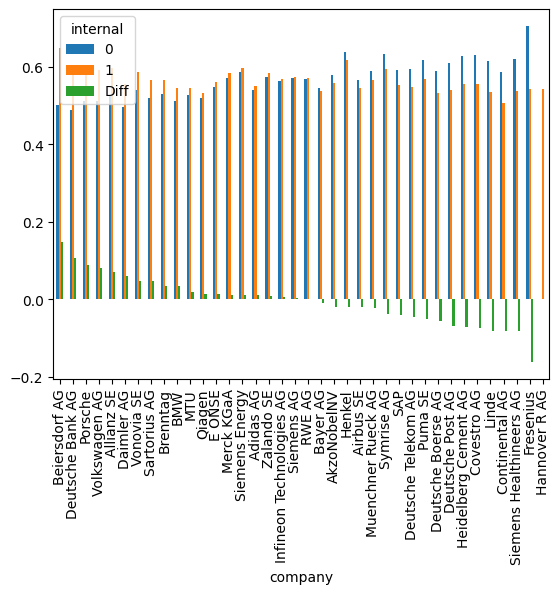

In [37]:
avg=df.groupby(["company","internal"])["polarity"].mean()
avg=avg.reset_index().pivot(index='company', columns='internal', values='polarity')
avg["Diff"]=avg[1]-avg[0]
avg.sort_values(by="Diff",ascending=False).plot(kind="bar")

Beirsdorf, Deutsche Bank and Porsche have the biggest gap difference in sentiment of internal and extenal documents.

Difference in average for companies:

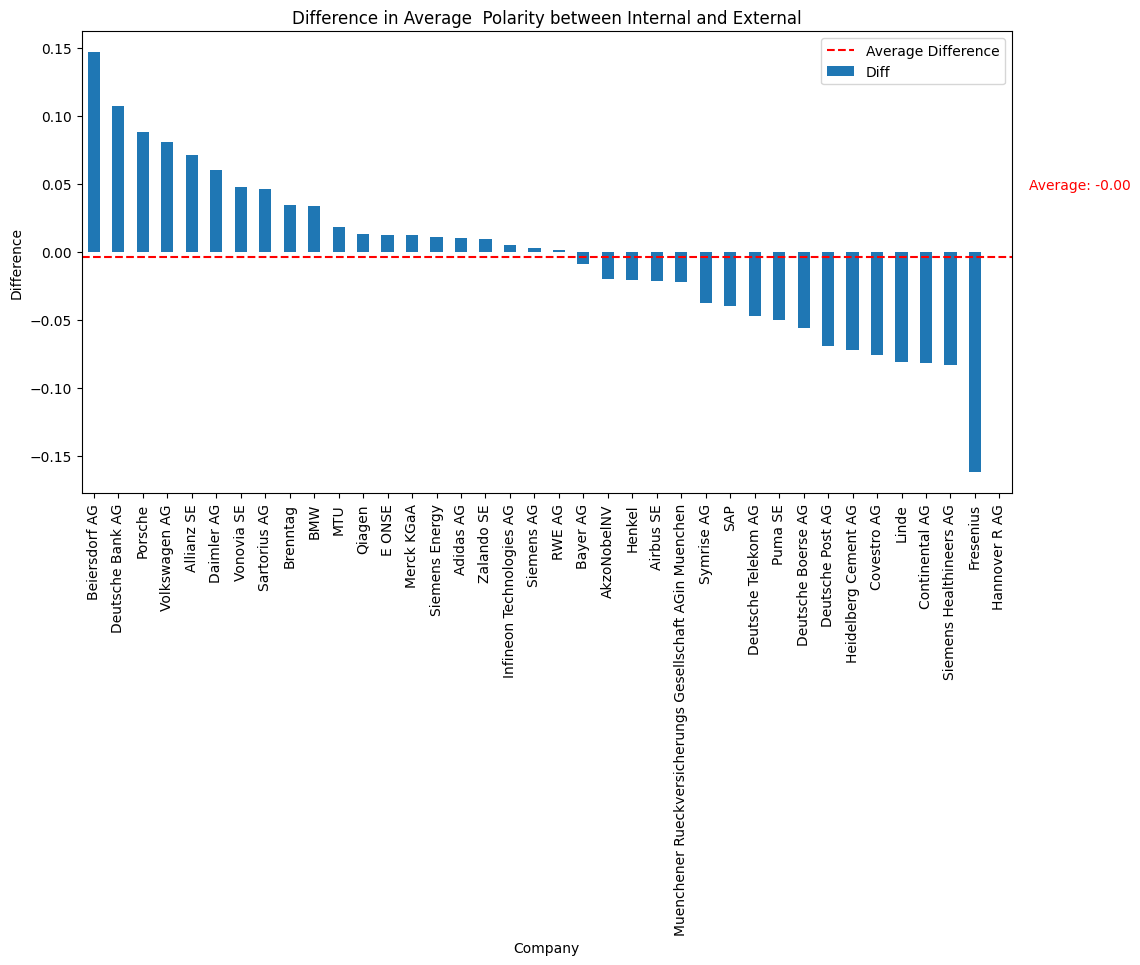

In [32]:
import matplotlib.pyplot as plt
avg_sorted = avg.sort_values(by="Diff", ascending=False)
average_difference = avg_sorted["Diff"].mean()
plt.figure(figsize=(12, 6)) 
avg_sorted["Diff"].plot(kind="bar")
plt.axhline(average_difference, color='red', linestyle='--', label='Average Difference')


plt.xlabel("Company")
plt.ylabel("Difference")
plt.title("Difference in Average  Polarity between Internal and External")
plt.xticks(rotation=90)
plt.text(len(avg_sorted)+0.2, average_difference+0.05, f"Average: {average_difference:.2f}", color='red')
plt.legend()
plt.show()


In [33]:
print("AVG Difference: ", average_difference )

AVG Difference:  -0.0036437425619618023


Classification report and confusion matrix:

In [34]:
predictions_test = trainer.predict(test_tok) # predict on the testset
logits_test = predictions_test.predictions
probabilities_test = F.softmax(torch.tensor(logits_test), dim=1)
predicted_labels_test = probabilities_test.argmax(axis=1)

Confusion Matrix:
[[ 9260   617   197]
 [  980 76766  2208]
 [  233  1337 19561]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     10074
           1       0.98      0.96      0.97     79954
           2       0.89      0.93      0.91     21131

    accuracy                           0.95    111159
   macro avg       0.92      0.94      0.93    111159
weighted avg       0.95      0.95      0.95    111159



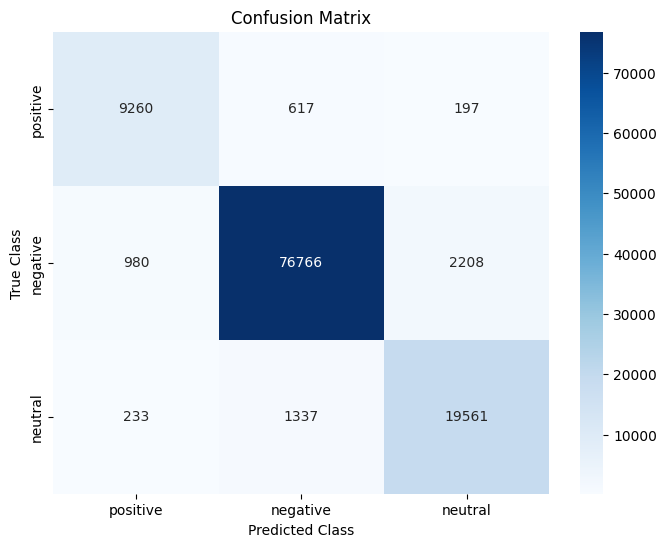

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# small Confusion Matrix
cm = confusion_matrix(test["labels"], predicted_labels_test)

# Calculation of the Classification Report
cr = classification_report(test["labels"], predicted_labels_test)

# Output of the Confusion Matrix and the Classification Report
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)

class_labels = ['positive', 'negative', 'neutral']

# Confusion Matrix big
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()